In [71]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model
import os
import random

In [111]:
def getGamma(infect, dead):
    
    recovG = approxRecovered(infect)
    infect = infect - recovG - dead
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    recovGD = np.diff(recovG)
    recovGD - recovGD.reshape((len(recovGD),1))

    gamma = np.linalg.lstsq(infect, recovGD, rcond = None)[0][0]
    return gamma

def getPop(state):
    path="../Data/"
    csvfile=open(path+"2020 Population Data.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][0]:
            pop = float(aData[i][1]) * 1000000
    return pop

def getPopC(county,state):
    path="../Data/"
    csvfile=open(path+"PopulationEstimates.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][1] and county in aData[i][2]:
            temp = aData[i][19]
            pop = float(temp.replace(',',''))
    return pop
def getNu(infect, dead):
    
    recovG = approxRecovered(infect)
    infect = infect - recovG - dead #current infected
    infect = infect[:-1].reshape((len(infect[:-1]),1))
    deadD = np.diff(dead)
    deadD - deadD.reshape((len(deadD),1))

    nu = np.linalg.lstsq(infect, deadD, rcond = None)[0][0]
    return nu

def approxRecovered(infect):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 13):
        recovG[i + 13] = infect[i] - dead[i + 13]
    return recovG


def getBeta(pop, q, infect, dead,winSize):
    

    sigma = regressionSlopeSeries(infect, winSize )
    recov = approxRecovered(infect)
    infectN = infect - recov - dead
    Z = infect 
    Zt = Z 
    It = infectN 
    halfwin = winSize // 2

    Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
    for i in range(len(Beta)):
        if np.isnan(Beta[i]):
            Beta[i] = 0
        if np.isinf(Beta[i]):
            Beta[i] = 0
    return Beta
    
    
def getRegressionSlope(points):
    """
    Takes a given number of points and outputs slope determined by linear regression
    Times can be included, if they are not, the indexes are assumed to be the times, starting from 0
    """
    timeArray = np.ones((len(points), 2))
    timeArray[:,1]  = np.arange(len(points))
    pointArray = np.array(points)
    point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
    slope = point_slope[1]
    return res, slope

def regressionSlopeSeries(points, window):
    """
    Given a series of points and a window size, estimates the slope at each point
    Outputs both the estimated slopes and regression errors for all applicable points
    If times list is provided, each of the included times should match up respectively with the points
    Window should be odd, if it isn't it will automatically be interpreted as one larger than the argument passed
    """
    # cut the window in half so we know how long it extends on both sides
    half_window = window//2
    num_points = len(points)
    slopes = []

    for i in range(num_points):
        # if there are not enough previous values to satisfy window size, continue
        if i < half_window:
            continue
        # if there are not enough values after the current one to satisfy window size, break
        if num_points-i <= half_window:
            break
        res, slope = getRegressionSlope(points[i-half_window: i+half_window])
        slopes.append(slope)

    slopes = np.array(slopes)
    return slopes

def getOandC(filename, smallerCategories = False):

    if(smallerCategories):
        bO = []
        sO = []
        bC = []
        sC = []
        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
       
        for i in range(len(aData)):
            if("Major Closure" in aData[i][1]):
                bC.append(aData[i][0])
            if("Minor Closure" in aData[i][1]):
                sC.append(aData[i][0])
            if("Minor Opening" in aData[i][1]):
                sO.append(aData[i][0])
            if("Major Opening" in aData[i][1]):
                bO.append(aData[i][0])

        return bO,sO,bC,sC
    else:
        O = []
        C = []

        csvfile=open(filename, newline='', encoding='UTF-8')
        rd = csv.reader(csvfile, delimiter=',')
        data=[]
        for lv in rd: #generating the data matrix
            data.append(lv)
        aData=(data[1:])
        for i in range(len(aData)):
            if("Closure" in aData[i][1]):
                C.append(aData[i][0])
            if("Opening" in aData[i][1]):
                O.append(aData[i][0])
        return O,C

    
def getMaskMandate(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    mM = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Mask Mandate" in aData[i][1]):
            if ("Lifted" not in aData[i][1]):
                mM.append(aData[i][0])
    return mM

def getMaskMandateLifted(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    mM = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Mask Mandate" in aData[i][1]):
            if ("Lifted" in aData[i][1]):
                mM.append(aData[i][0])
    return mM


def getStayAtHome(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Stay at Home Order" in aData[i][1]):
            if ("Lifted" not in aData[i][1]):
                sC.append(aData[i][0])
    return sC


def getStayAtHomeLifted(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Stay at Home Order" in aData[i][1]):
            if ("Lifted" in aData[i][1]):
                sC.append(aData[i][0])
    return sC

def getSchoolClosure(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("School Closure" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getSchoolOpening(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("School Opening" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getRestrictionsLifted(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("All Restrictions Lifted" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getPublicFacilitiesOpened(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Public Facility Opened" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getPublicFacilitiesClosed(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Public Facility Closed" in aData[i][1]):
            sC.append(aData[i][0])
    return sC

def getGatheringsAllowed(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Gatherings Allowed" in aData[i][1]):
            sC.append(aData[i][0])
    return sC
       
def getGatheringsDisallowed(filename,dates):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    sC = []
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[1:])
   
    while (len(aData[-1]) == 0):
        aData = aData[:-1]
    for i in range(len(aData)):
        if("Gatherings Disallowed" in aData[i][1]):
            sC.append(aData[i][0])
    return sC
    
def displayOandC(filename, beta, ax, dates,window, smallerCategories = False):
    #Add or modify dates for closures or openings here

    if(smallerCategories):
        bOpening,sOpening, bClosure, sClosure = getOandC(filename, smallerCategories)

        bOind = []
        sOind = []
        bCind = []
        sCind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(bOpening)):
            bOind.append(temp.index(bOpening[i]))
        for i in range(len(sOpening)):
            sOind.append(temp.index(sOpening[i]))
        for i in range(len(bClosure)):
            bCind.append(temp.index(bClosure[i]))
        for i in range(len(sClosure)):
            sCind.append(temp.index(sClosure[i]))

        #Variables used to fix legend duplications
        temp1 = 0
        temp3 = 0
        temp2 = 0
        temp4 = 0
        #Add the dashed lines going up to the beta curve

        for i in range(len(bOind)): 
            if(temp1 == 0):
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]], label = "Major Openings")
                temp1 = 1
            else:
                plt.vlines(x = bOind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[bOind[i]] )
        for i in range(len(sOind)): 
            if(temp3 == 0):
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]], label = "Minor Openings")
                temp3 = 1
            else:
                plt.vlines(x = sOind[i] + hWin,color ='orange',ymin = 0,linestyle = 'dashed', ymax = beta[sOind[i]] )
        for i in range(len(bCind)):
            if(temp2 == 0):
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]], label = "Major Closures")
                temp2 = 1
            else:
                plt.vlines(x = bCind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[bCind[i]])
        for i in range(len(sCind)):
            if(temp4 == 0):
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]], label = "Minor Closures")
                temp4 = 1
            else:
                plt.vlines(x = sCind[i] + hWin,color ='cyan',ymin = 0,linestyle = 'dashed', ymax = beta[sCind[i]])
        ax.legend(fontsize=20)
    else:
        Opening, Closure = getOandC(filename, smallerCategories)

        Oind = []
        Cind = []

        hWin = window // 2
        temp = dates.tolist()
        #Get the indexes for each opening or closing date
        for i in range(len(Opening)):
            Oind.append(temp.index(Opening[i]))
        for i in range(len(Closure)):
            Cind.append(temp.index(Closure[i]))


        #Variables used to fix legend duplications
        temp1 = 0
        temp2 = 0

        #Add the dashed lines going up to the beta curve
        for i in range(len(Oind)): 
            if(temp1 == 0):
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]], label = "Openings")
                temp1 = 1
            else:
                plt.vlines(x = Oind[i] + hWin,color ='red',ymin = 0,linestyle = 'dashed', ymax = beta[Oind[i]] )
        for i in range(len(Cind)):
            if(temp2 == 0):
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]], label = "Closures")
                temp2 = 1
            else:
                plt.vlines(x = Cind[i] + hWin,color ='green',ymin = 0,linestyle = 'dashed', ymax = beta[Cind[i]])
        ax.legend(fontsize=20)
    
#predict the next some days using constant parameters
def calculateFuture(infect, recov, dead, pop, daysToPredict, params, q):
    
    #A=sirdmatrix, and dt=nextIterMatrix, if we know S(t) we should be able to predict S(t+1)
    suscept = q*pop - infect - recov - dead
    dt, A = SIRD_Model.getSIRDMatrices(suscept, infect, recov, dead)

    sirdPredict = np.zeros((len(A) + daysToPredict, 4, 3))
    dtPredict = np.zeros((len(dt) + daysToPredict, 4, 1))

    sirdPredict[0:len(A)] = A
    dtPredict[0:len(dt)] = dt

    susceptPredict = np.zeros(len(suscept) + daysToPredict)
    infectPredict = np.zeros(len(infect) + daysToPredict)
    recovPredict = np.zeros(len(recov) + daysToPredict)
    deadPredict = np.zeros(len(dead) + daysToPredict)

    susceptPredict[0:len(suscept)] = suscept
    infectPredict[0:len(infect)] = infect
    recovPredict[0:len(recov)] = recov
    deadPredict[0:len(dead)] = dead

    T = len(suscept)
    for t in range(T-1, T + daysToPredict - 1): #go from last element in known list to end of prediction, see paper for method
        #populate the 4x3 matrix with parameters
        sirdPredict[t,0,0] = -(susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,0] = (susceptPredict[t] * infectPredict[t]) / (susceptPredict[t] + infectPredict[t])
        sirdPredict[t,1,1] = -infectPredict[t]
        sirdPredict[t,1,2] = -infectPredict[t]
        sirdPredict[t,2,1] = infectPredict[t]
        sirdPredict[t,3,2] = infectPredict[t]

        #find next dtPredict
        dtPredict[t,:,0] = (sirdPredict[t] @ params)

        #find next SIRD, based on dtPredict[t] (which is S(t+1) - S(t)) to predict S(t) (and so on)
        susceptPredict[t+1] = susceptPredict[t] + dtPredict[t,0,0]
        infectPredict[t+1] = infectPredict[t] + dtPredict[t,1,0]
        recovPredict[t+1] = recovPredict[t] + dtPredict[t,2,0]
        deadPredict[t+1] = deadPredict[t] + dtPredict[t,3,0]
    
    return susceptPredict, infectPredict, recovPredict, deadPredict, q, params


#predict future days that are not known
def predictFuture(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect, recov, dead, pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))
    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')

    
#predict days that are known for testing purposes, predicts the end portion of the given data
def predictMatch(infect, recov, dead, pop, daysToPredict, param, qVal, graphVals=[True,True,True,True]):
    pS, pI, pR, pD, q, params = calculateFuture(infect[0:-daysToPredict], recov[0:-daysToPredict], dead[0:-daysToPredict], pop, daysToPredict, param, qVal)
    
    suscept = q*pop - infect - recov - dead
    
    #plot actual and predicted values
    fig, ax = plt.subplots(figsize=(18,8))

    if(graphVals[0]):
        ax.plot(suscept, color='blue', label='suscpetible')
        ax.plot(pS, color='blue', label='suscpetible', linestyle='dashed')
    if(graphVals[1]):
        ax.plot(infect, color='orange', label='infected')
        ax.plot(pI, color='orange', label='infected', linestyle='dashed')
    if(graphVals[2]):
        ax.plot(recov, color='green', label='recovered')
        ax.plot(pR, color='green', label='recovered', linestyle='dashed')
    if(graphVals[3]):
        ax.plot(dead, color='black', label='dead')
        ax.plot(pD, color='black', label='dead', linestyle='dashed')
        
def getBetaDiffC(dates,simDate,beta,infect,dead,pop,q,numDays,lag = 7):

    temp = dates.tolist()
    recov = approxRecovered(infect)
    
    sI = simDate[0:len(simDate)-4]
    sA = simDate[len(simDate) - 2: len(simDate)]
    simDate = sI + sA
    simLastEl = temp.index(simDate) + 14+lag >= len(temp)
    if(simLastEl):
        endDate = dates[(len(beta))]
    else:
        endDate = dates[temp.index(simDate)+14+lag]
    startDate = dates[temp.index(simDate)-14]
    #catch markers on edge
    if(temp.index(startDate) >= temp.index(simDate)):
        startDate = dates[0]

    
   

    temp = dates.tolist()
    startInd = temp.index(startDate)
    simInd = temp.index(simDate)
    endInd = temp.index(endDate)


   
    #print(startInd, simInd, endInd)
    simBetaAfter = np.average(beta[simInd+lag:endInd])
    simBetaBefore = np.average(beta[startInd:simInd])
    betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
  
    recov = approxRecovered(infect)
    currInfect = infect - dead - recov
    paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
    paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]
    infectT = currInfect[:endInd]
    recovT = recov[:endInd]
    deadT = dead[:endInd]
   
    daysToPredict = (endInd - simInd)
    
    pS, pI, pR, pDB, q, paramB = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramB, q)

    #plot actual and predicted values
    
    pS, pI, pR, pDA, q, paramA = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramA, q)
    
    
    return simBetaBefore, simBetaAfter

def getBetaDiff(dates,simDate,beta,infect,dead,pop,q,numDays):

    temp = dates.tolist()
    recov = approxRecovered(infect)

    simLastEl = temp.index(simDate) + 21 >= len(temp)
    if(simLastEl):
        endDate = dates[(len(beta))]
    else:
        endDate = dates[temp.index(simDate)+21]
    startDate = dates[temp.index(simDate)-14]
    #catch markers on edge
    if(temp.index(startDate) >= temp.index(simDate)):
        startDate = dates[0]

    
   

    temp = dates.tolist()
    startInd = temp.index(startDate)
    simInd = temp.index(simDate)
    endInd = temp.index(endDate)


   
    #print(startInd, simInd, endInd)
    simBetaAfter = np.average(beta[simInd+7:endInd])
    simBetaBefore = np.average(beta[startInd:simInd])
    betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
    
    
    recov = approxRecovered(infect)
    currInfect = infect - dead - recov
    paramA = [simBetaAfter, getGamma(infect, dead), getNu(infect, dead)]
    paramB = [simBetaBefore, getGamma(infect, dead), getNu(infect, dead)]
    infectT = currInfect[:endInd]
    recovT = recov[:endInd]
    deadT = dead[:endInd]
   
    daysToPredict = (endInd - simInd)
    
    pS, pI, pR, pDB, q, paramB = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramB, q)

    #plot actual and predicted values
    
    pS, pI, pR, pDA, q, paramA = calculateFuture(infectT[0:-daysToPredict], recovT[0:-daysToPredict], deadT[0:-daysToPredict], pop, daysToPredict, paramA, q)
    
    
    return simBetaBefore, simBetaAfter
    
def betaWithKernel(beta): #Apply a convolution kernel to the data
    x = np.arange(-7, 8)
    kernel2 = np.exp(-(x) ** 2 / (2 * 7 ** 2))#The middle term on the right is the sigma value
    kernel2=kernel2/sum(kernel2)
    newBeta = np.convolve(beta, kernel2, 'same')
    return newBeta




convert = {
    'AL':'Alabama',
    'AK':'Alaska',
    'AS':'American Samoa' ,
    'AZ':'Arizona' ,
    'AR':'Arkansas',
    'CA':'California',
    'CO':'Colorado',
    'CT':'Connecticut',
    'DE':'Delaware',
    'DC':'District of Columbia',
    'FL':'Florida',
    'GA':'Georgia',
    'GU':'Guam',
    'HI':'Hawaii',
    'ID':'Idaho',
    'IL':'Illinois',
    'IN':'Indiana',
    'IA':'Iowa',
    'KS':'Kansas',
    'KY':'Kentucky',
    'LA':'Louisiana',
    'ME':'Maine',
    'MD':'Maryland',
    'MA':'Massachusetts',
    'MI':'Michigan',
    'MN':'Minnesota',
    'MS':'Mississippi',
    'MO':'Missouri',
    'MT':'Montana',
    'NE':'Nebraska',
    'NV':'Nevada',
    'NH':'New Hampshire',
    'NJ':'New Jersey',
    'NM':'New Mexico',
    'NY':'New York',
    'NC':'North Carolina',
    'ND':'North Dakota',
    'MP':'Northern Mariana Island',
    'OH':'Ohio',
    'OK':'Oklahoma',
    'OR':'Oregon',
    'PA':'Pennsylvania',
    'PR':'Puerto Rico',
    'RI':'Rhode Island',
    'SC':'South Carolina',
    'SD':'South Dakota',
    'TN':'Tennessee',
    'TX':'Texas',
    'UT':'Utah',
    'VT':'Vermont',
    'VA':'Virginia',
    'VI':'Virgin Islands',
    'WA':'Washington',
    'WV':'West Virginia',
    'WI':'Wisconsin',
    'WY':'Wyoming'
    
}

convert.update(dict(reversed(item) for item in convert.items()))

# Mask Mandate Distribution

['Alabama Closure Data.csv', 'Alaska Closure Data.csv', 'Arizona Closure Data.csv', 'Arkansas Closure Data.csv', 'California Closure Data.csv', 'Colorado Closure Data.csv', 'Connecticut Closure Data.csv', 'Delaware Closure Data.csv', 'Florida Closure Data.csv', 'Georgia Closure Data.csv', 'Hawaii Closure Data.csv', 'Idaho Closure Data.csv', 'Illinois Closure Data.csv', 'New York Closure Data.csv', 'Texas closure data.csv']


<ipython-input-72-33d5794910f5>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)


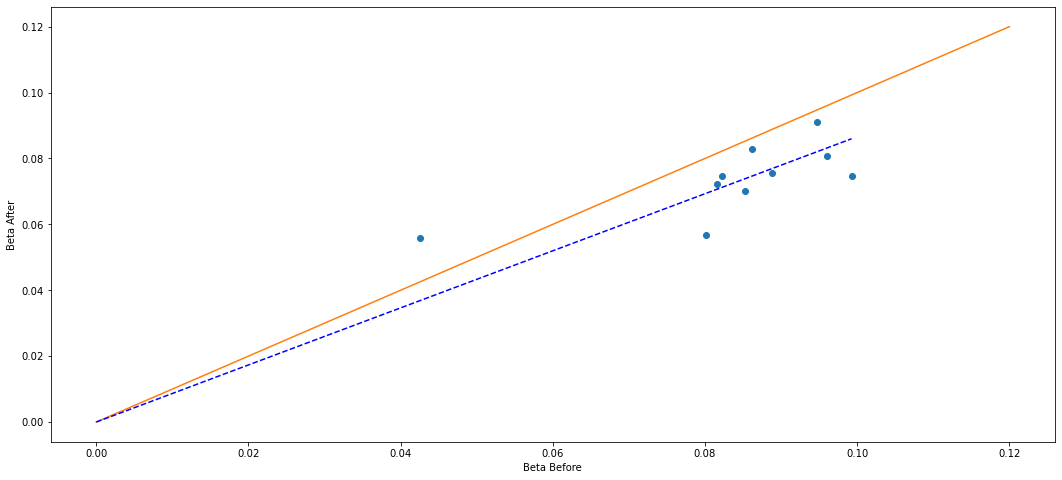

In [77]:
arr = os.listdir('../Data/State Closure Data/Data files that Jesse messed with/')
print(arr)

bB = []
bA = []

for file in arr:
    pathc='../Data/Covid Tracking State Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    
    stateName = file[0:len(file)-17] #Get the county name
    abr = convert[stateName]
    #Change state abbreviation based on the state you want to use
    filename = abr+".csv"

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

    #Change population based on the state you want to use
    pop = int(getPop(stateName))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = .1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    
   
    temp = dates.tolist()
    pathc='../Data/State Closure Data/Data files that Jesse messed with/'
    mM = getMaskMandate(pathc+file, dates)
    for k in range(len(mM)): 
        tB, tA = getBetaDiff(dates,mM[k], beta, infect, dead, pop, q, numDays )
        bB.append(tB)
        bA.append(tA)
    i += 1
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o')
ax.plot([0,0.12],[0,0.12])
ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")
bB = np.array(bB)
bB = bB[:,np.newaxis]
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]

#Plotting Line of best fit
x = np.linspace(0, bB.max())
ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')


# Generating a Control Distribution

['Alabama Closure Data.csv', 'Alaska Closure Data.csv', 'Arizona Closure Data.csv', 'Arkansas Closure Data.csv', 'California Closure Data.csv', 'Colorado Closure Data.csv', 'Connecticut Closure Data.csv', 'Delaware Closure Data.csv', 'Florida Closure Data.csv', 'Georgia Closure Data.csv', 'Hawaii Closure Data.csv', 'Idaho Closure Data.csv', 'Illinois Closure Data.csv', 'New York Closure Data.csv', 'Texas closure data.csv']


<ipython-input-72-33d5794910f5>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)


['Alabama Closure Data.csv', 'Alaska Closure Data.csv', 'Arizona Closure Data.csv', 'Arkansas Closure Data.csv', 'California Closure Data.csv', 'Colorado Closure Data.csv', 'Connecticut Closure Data.csv', 'Delaware Closure Data.csv', 'Florida Closure Data.csv', 'Georgia Closure Data.csv', 'Hawaii Closure Data.csv', 'Idaho Closure Data.csv', 'Illinois Closure Data.csv', 'New York Closure Data.csv', 'Texas closure data.csv']
['Alabama Closure Data.csv', 'Alaska Closure Data.csv', 'Arizona Closure Data.csv', 'Arkansas Closure Data.csv', 'California Closure Data.csv', 'Colorado Closure Data.csv', 'Connecticut Closure Data.csv', 'Delaware Closure Data.csv', 'Florida Closure Data.csv', 'Georgia Closure Data.csv', 'Hawaii Closure Data.csv', 'Idaho Closure Data.csv', 'Illinois Closure Data.csv', 'New York Closure Data.csv', 'Texas closure data.csv']
['Alabama Closure Data.csv', 'Alaska Closure Data.csv', 'Arizona Closure Data.csv', 'Arkansas Closure Data.csv', 'California Closure Data.csv', 'C

Text(0, 0.5, 'Beta After')

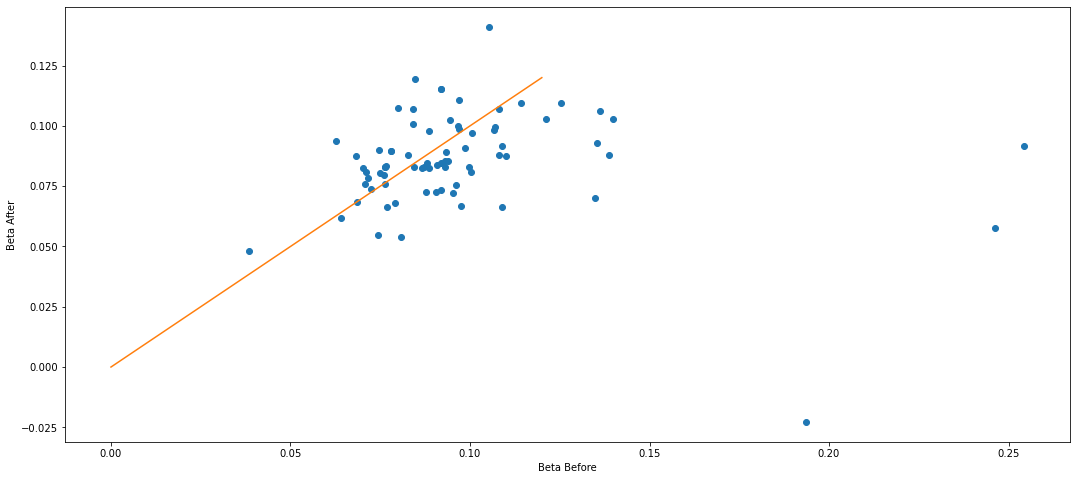

In [84]:
bB = []
bA = []
for i in range(5):
    arr = os.listdir('../Data/State Closure Data/Data files that Jesse messed with/')
    print(arr)

    for file in arr:
    
        stateName = file[0:len(file)-17] #Get the county name
        abr = convert[stateName]
        
        pathc='../Data/Covid Tracking State Data/'
        # modify the path syntax based on the current platform
        if platform.system() == "Windows":
            pathc.replace("/", "\\")

        #Change state abbreviation based on the state you want to use
        filename = abr+".csv"

        dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + filename)

        #Change population based on the state you want to use
        pop = int(getPop(stateName))
        numDays = len(infectRaw)
        infect = infectRaw[0:numDays]
        dead = deadRaw[0:numDays]

        gamma = getGamma(infect,dead)
        nu = getNu(infect,dead)
        q = .1 #0.0754
        window = 13
        hWin = window // 2
        beta = getBeta(pop, q, infect, dead, window)


        temp = dates.tolist()
        pathc='../Data/State Closure Data/Data files that Jesse messed with/'
        randDate = dates[random.randint(14,len(dates)-21)]

        tB, tA = getBetaDiff(dates,randDate, beta, infect, dead, pop, q, numDays )
        bB.append(tB)
        bA.append(tA)
        i += 1
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o')
ax.plot([0,0.12],[0,0.12])

ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")

# County Stay at Home Order

['.DS_Store', 'Arapahoe County, CO.csv', 'Contra Costa County, CA.csv', 'Cook County, IL.csv', 'Dallas County, TX.csv', 'Fulton County, GA.csv', 'Harris County, TX.csv', 'Los Angeles County, CA.csv', 'Maricopa County, AZ.csv', 'Miami-Dade County, FL.csv', 'Orange County, CA.csv', 'Riverside County, CA.csv', 'San Bernardino County, CA.csv', 'San Diego County, CA.csv', 'Santa Clara County, CA.csv']


<ipython-input-111-b4d6ed2d9065>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]


The expected average percentage change in beta is:  -56.41258182975193 %


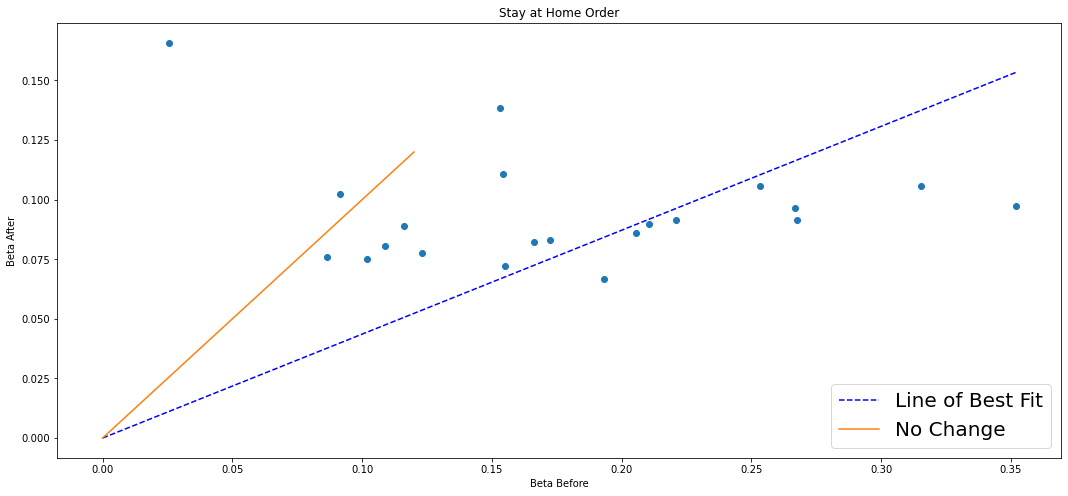

In [116]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

bB = [] #Store the Beta Before Values
bA = [] #Store the Beta After Values

for file in arr:
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    #beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    mM = getStayAtHome(pathc+file, dates)
    
    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    for k in range(len(mM)): 
        tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
        bB.append(tB)
        bA.append(tA)
        
#Get rid of weird invalid cases
i = 0
while i < len(bB):
    if bB[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bB[i]):
        del bB[i]
        del bA[i]
        i-= 1
    if np.isinf(bB[i]):
        del bB[i]
        del bA[i]
        i-=1
    i+=1
    
i = 0
while i < len(bA):
    if bA[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bA[i]):
        del bB[i]
        del bA[i]
        i-=1
    if np.isinf(bA[i]):
        del bB[i]
        del bA[i]  
        i-=1
    i+=1
#Plotting the beta before and after points
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o')

#Creating the line of best fit
bB = np.array(bB)
bB = bB[:,np.newaxis]
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]

#Plotting Line of best fit
x = np.linspace(0, bB.max())
ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')

#Plotting line y=x
ax.plot([0,0.12],[0,0.12], label = 'No Change')

#ax.axis([0,0.12,0,0.12])
ax.set_title("Stay at Home Order")
ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)

print("The expected average percentage change in beta is: ", (float(bestFit)-1) * 100, "%")

# County Mask Mandate

['.DS_Store', 'Arapahoe County, CO.csv', 'Contra Costa County, CA.csv', 'Cook County, IL.csv', 'Dallas County, TX.csv', 'Fulton County, GA.csv', 'Harris County, TX.csv', 'Los Angeles County, CA.csv', 'Maricopa County, AZ.csv', 'Miami-Dade County, FL.csv', 'Orange County, CA.csv', 'Riverside County, CA.csv', 'San Bernardino County, CA.csv', 'San Diego County, CA.csv', 'Santa Clara County, CA.csv']


<ipython-input-111-b4d6ed2d9065>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]


The expected average percentage change in beta is:  -30.952815136860558 %


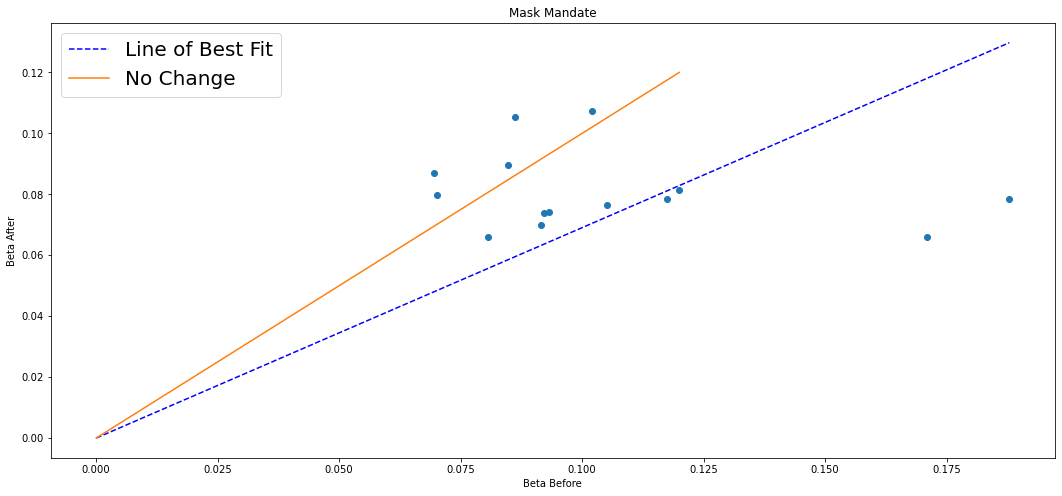

In [117]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

bB = [] #Store the Beta Before Values
bA = [] #Store the Beta After Values

for file in arr:
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    mM = getMaskMandate(pathc+file, dates)
    
    
    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    for k in range(len(mM)): 
        tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
        bB.append(tB)
        bA.append(tA)

#Get rid of weird invalid cases
i = 0
while i < len(bB):
    if bB[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bB[i]):
        del bB[i]
        del bA[i]
        i-= 1
    if np.isinf(bB[i]):
        del bB[i]
        del bA[i]
        i-=1
    i+=1
    
i = 0
while i < len(bA):
    if bA[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bA[i]):
        del bB[i]
        del bA[i]
        i-=1
    if np.isinf(bA[i]):
        del bB[i]
        del bA[i]  
        i-=1
    i+=1
#Plotting the beta before and after points
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o')

#Creating the line of best fit
bB = np.array(bB)
bB = bB[:,np.newaxis]
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]

#Plotting Line of best fit
x = np.linspace(0, bB.max())
ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')

#Plotting line y=x
ax.plot([0,0.12],[0,0.12], label = 'No Change')

#ax.axis([0,0.12,0,0.12])
ax.set_title("Mask Mandate")
ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)

print("The expected average percentage change in beta is: ", (float(bestFit)-1) * 100, "%")

['.DS_Store', 'Arapahoe County, CO.csv', 'Contra Costa County, CA.csv', 'Cook County, IL.csv', 'Dallas County, TX.csv', 'Fulton County, GA.csv', 'Harris County, TX.csv', 'Los Angeles County, CA.csv', 'Maricopa County, AZ.csv', 'Miami-Dade County, FL.csv', 'Orange County, CA.csv', 'Riverside County, CA.csv', 'San Bernardino County, CA.csv', 'San Diego County, CA.csv', 'Santa Clara County, CA.csv']
3/12/2020
0.056782215955276445 0.17420618206940133
11/16/2020
0.09644753247477178 0.0752048366459399


<ipython-input-111-b4d6ed2d9065>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]


3/17/2020
0.3323341307204069 0.1256225356171777
3/16/2020
0.11500548224009302 0.11377478491414629
3/9/2020
0.09841907179739022 0.17041375344717338
3/16/2020
0.16462395429624826 0.1695978929938565


<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]


3/16/2020
0.30868660233467154 0.11124035189932087
3/16/2020
0.11771656177201557 0.14622453914106323
3/13/2020
0.06628644548127946 0.2029615820861159
3/17/2020
0.025693385771817703 0.16585054143481068
3/13/2020
0.36767296325191945 0.13935852997871123
3/16/2020
0.17530406302190338 0.08698447765731607
The expected average percentage change in beta is:  -44.289552016029724 %


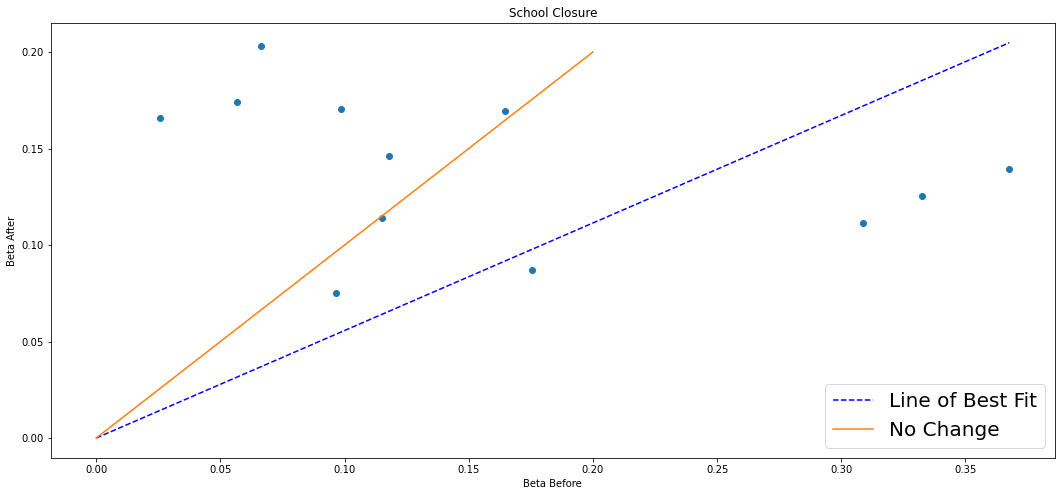

In [118]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

bB = [] #Store the Beta Before Values
bA = [] #Store the Beta After Values

for file in arr:
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    #beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    mM = getSchoolClosure(pathc+file, dates)
    

    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    for k in range(len(mM)): 
        if mM[k] not in "":
            print(mM[k])
            tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
            bB.append(tB)
            bA.append(tA)
            print(tB,tA)
            
#Get rid of weird invalid cases
i = 0
while i < len(bB):
    if bB[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bB[i]):
        del bB[i]
        del bA[i]
        i-= 1
    if np.isinf(bB[i]):
        del bB[i]
        del bA[i]
        i-=1
    i+=1
    
i = 0
while i < len(bA):
    if bA[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bA[i]):
        del bB[i]
        del bA[i]
        i-=1
    if np.isinf(bA[i]):
        del bB[i]
        del bA[i]  
        i-=1
    i+=1
#Plotting the beta before and after points
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o')

#Creating the line of best fit
bB = np.array(bB)
bB = bB[:,np.newaxis]
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]

#Plotting Line of best fit
x = np.linspace(0, bB.max())
ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')

#Plotting line y=x
ax.plot([0,0.2],[0,0.2], label = 'No Change')

#ax.axis([0,0.2,0,0.2])
ax.set_title("School Closure")
ax.set_xlabel("Beta Before")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)


print("The expected average percentage change in beta is: ", (float(bestFit)-1) * 100, "%")

['.DS_Store', 'Arapahoe County, CO.csv', 'Contra Costa County, CA.csv', 'Cook County, IL.csv', 'Dallas County, TX.csv', 'Fulton County, GA.csv', 'Harris County, TX.csv', 'Los Angeles County, CA.csv', 'Maricopa County, AZ.csv', 'Miami-Dade County, FL.csv', 'Orange County, CA.csv', 'Riverside County, CA.csv', 'San Bernardino County, CA.csv', 'San Diego County, CA.csv', 'Santa Clara County, CA.csv']


<ipython-input-111-b4d6ed2d9065>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
<ipython-input-111-b4d6ed2d9065>:549: RuntimeWarning: divide by zero encountered in double_scalars
  betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100


The expected average percentage change in beta is:  4.748910205147161 %


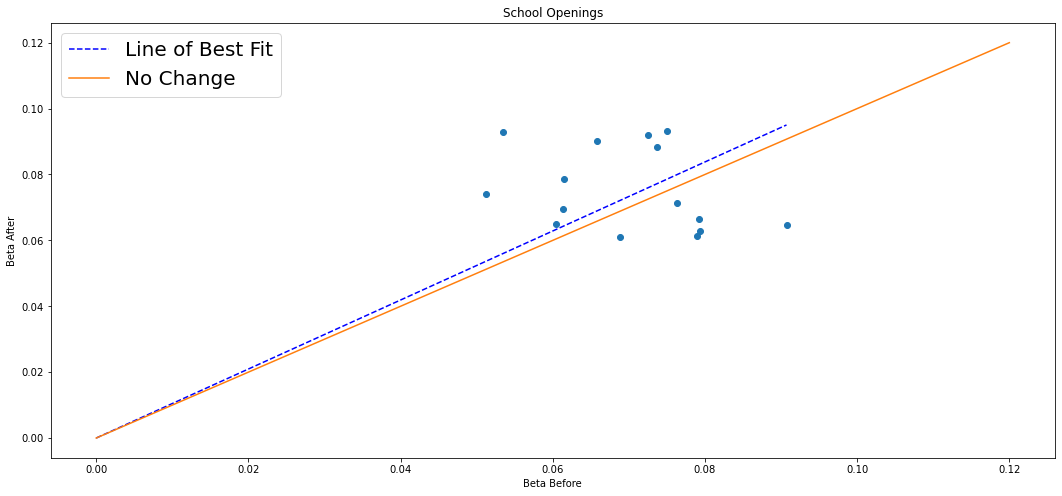

In [119]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

bB = [] #Store the Beta Before Values
bA = [] #Store the Beta After Values

for file in arr:
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    mM = getSchoolOpening(pathc+file, dates)
    
    
    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    for k in range(len(mM)): 
        tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
        bB.append(tB)
        bA.append(tA)
        
#Get rid of weird invalid cases
i = 0
while i < len(bB):
    if bB[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bB[i]):
        del bB[i]
        del bA[i]
        i-= 1
    if np.isinf(bB[i]):
        del bB[i]
        del bA[i]
        i-=1
    i+=1
    
i = 0
while i < len(bA):
    if bA[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bA[i]):
        del bB[i]
        del bA[i]
        i-=1
    if np.isinf(bA[i]):
        del bB[i]
        del bA[i]  
        i-=1
    i+=1
#Plotting the beta before and after points
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o')

#Creating the line of best fit
bB = np.array(bB)
bB = bB[:,np.newaxis]
      
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]

#Plotting Line of best fit
x = np.linspace(0, bB.max())
ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')

#Plotting line y=x
ax.plot([0,0.12],[0,0.12], label = 'No Change')

#ax.axis([0,0.12,0,0.12])
ax.set_xlabel("Beta Before")
ax.set_title("School Openings")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)

print("The expected average percentage change in beta is: ", (float(bestFit)-1) * 100, "%")

# Stay at Home Lifted

['.DS_Store', 'Arapahoe County, CO.csv', 'Contra Costa County, CA.csv', 'Cook County, IL.csv', 'Dallas County, TX.csv', 'Fulton County, GA.csv', 'Harris County, TX.csv', 'Los Angeles County, CA.csv', 'Maricopa County, AZ.csv', 'Miami-Dade County, FL.csv', 'Orange County, CA.csv', 'Riverside County, CA.csv', 'San Bernardino County, CA.csv', 'San Diego County, CA.csv', 'Santa Clara County, CA.csv']


<ipython-input-111-b4d6ed2d9065>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]


The expected average percentage change in beta is:  -7.233846322970628 %


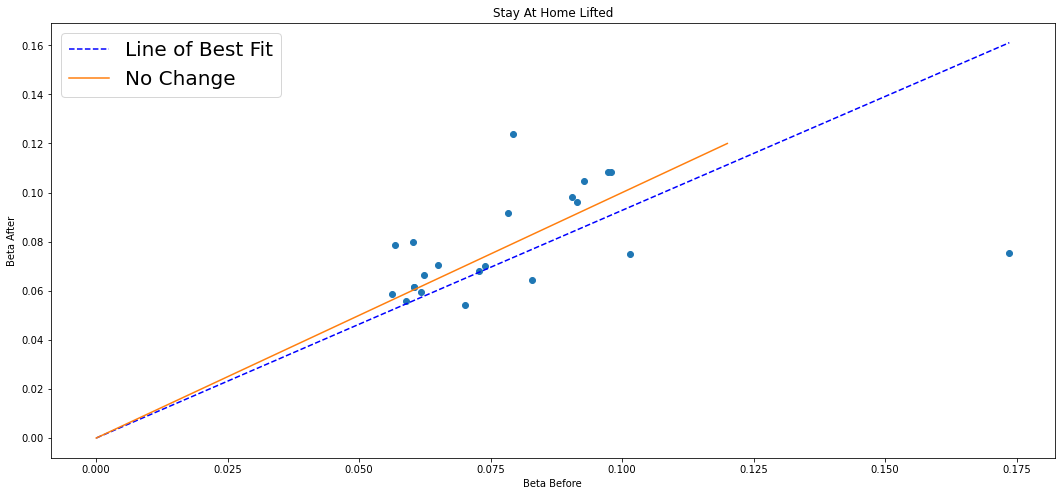

In [129]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

bB = [] #Store the Beta Before Values
bA = [] #Store the Beta After Values

for file in arr:
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    mM = getStayAtHomeLifted(pathc+file, dates)
    
    
    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    for k in range(len(mM)): 
        tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays) 
        bB.append(tB)
        bA.append(tA)
        
#Get rid of weird invalid cases
i = 0
while i < len(bB):
    if bB[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bB[i]):
        del bB[i]
        del bA[i]
        i-= 1
    if np.isinf(bB[i]):
        del bB[i]
        del bA[i]
        i-=1
    i+=1
    
i = 0
while i < len(bA):
    if bA[i] == 0:
        del bB[i]
        del bA[i]
        i-= 1
    if np.isnan(bA[i]):
        del bB[i]
        del bA[i]
        i-=1
    if np.isinf(bA[i]):
        del bB[i]
        del bA[i]  
        i-=1
    i+=1
#Plotting the beta before and after points
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(bB,bA, 'o')

#Creating the line of best fit
bB = np.array(bB)
bB = bB[:,np.newaxis]
      
bestFit = np.linalg.lstsq(bB,bA, rcond = None)[0]

#Plotting Line of best fit
x = np.linspace(0, bB.max())
ax.plot(x,x*bestFit,color = "blue", linestyle = 'dashed', label = 'Line of Best Fit')

#Plotting line y=x
ax.plot([0,0.12],[0,0.12], label = 'No Change')

#ax.axis([0,0.12,0,0.12])
ax.set_xlabel("Beta Before")
ax.set_title("Stay At Home Lifted")
ax.set_ylabel("Beta After")
ax.legend(fontsize = 20)

print("The expected average percentage change in beta is: ", (float(bestFit)-1) * 100, "%")

# Difference as a Function of Lag

['.DS_Store', 'Arapahoe County, CO.csv', 'Contra Costa County, CA.csv', 'Cook County, IL.csv', 'Dallas County, TX.csv', 'Fulton County, GA.csv', 'Harris County, TX.csv', 'Los Angeles County, CA.csv', 'Maricopa County, AZ.csv', 'Miami-Dade County, FL.csv', 'Orange County, CA.csv', 'Riverside County, CA.csv', 'San Bernardino County, CA.csv', 'San Diego County, CA.csv', 'Santa Clara County, CA.csv']


<ipython-input-111-b4d6ed2d9065>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]
C:\Users\Jesse\Python\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jesse\Python\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalar

Text(0, 0.5, 'Difference in Beta')

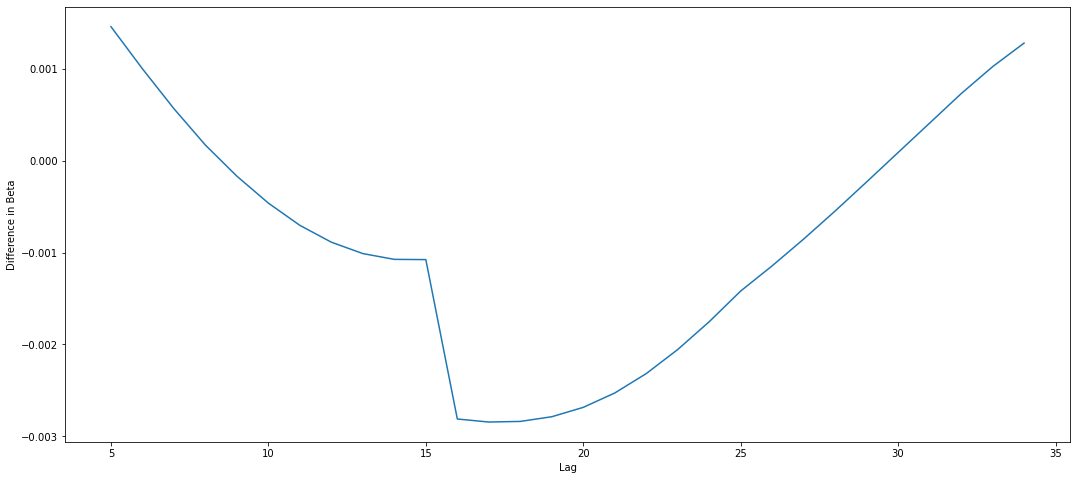

In [130]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)

cB = []

for j in range(5,35):
    bB = [] #Store the Beta Before Values
    bA = [] #Store the Beta After Values
    for file in arr:
        pathc='../Data/JHU Data/County Data/'
        # modify the path syntax based on the current platform
        if platform.system() == "Windows":
            pathc.replace("/", "\\")
        if '.DS_Store' in file:
            continue
        #Change state abbreviation based on the state you want to use

        dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)


        cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
        cName = convert[cState]
        cCounty = file[0:file.index(',')] #Get the county name

        #Change population based on the county you want to use
        pop = int(getPopC(cCounty,cState))
        numDays = len(infectRaw)
        infect = infectRaw[0:numDays]
        dead = deadRaw[0:numDays]

        gamma = getGamma(infect,dead)
        nu = getNu(infect,dead)
        q = 1 #0.0754
        window = 13
        hWin = window // 2
        beta = getBeta(pop, q, infect, dead, window)
        beta = betaWithKernel(beta)
        #fig, ax = plt.subplots(figsize= (18,8))
        #ax.plot(beta)
        temp = dates.tolist()
        pathc='../Data/State Closure Data/County Closure Data/'

        #Change function call of mM to change the policy
        mM = getStayAtHomeLifted(pathc+file, dates)


        #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
        for k in range(len(mM)): 
            tB, tA = getBetaDiffC(dates,mM[k], beta, infect, dead, pop, q, numDays, lag = j) 
            bB.append(tB)
            bA.append(tA)

    #Get rid of weird invalid cases
    i = 0
    while i < len(bB):
        if bB[i] == 0:
            del bB[i]
            del bA[i]
            i-= 1
        if np.isnan(bB[i]):
            del bB[i]
            del bA[i]
            i-= 1
        if np.isinf(bB[i]):
            del bB[i]
            del bA[i]
            i-=1
        i+=1

    i = 0
    while i < len(bA):
        if bA[i] == 0:
            del bB[i]
            del bA[i]
            i-= 1
        if np.isnan(bA[i]):
            del bB[i]
            del bA[i]
            i-=1
        if np.isinf(bA[i]):
            del bB[i]
            del bA[i]  
            i-=1
        i+=1
    cB.append(np.mean(bB) - np.mean(bA))
fig,ax = plt.subplots(figsize = (18,8))
ax.plot(range(5,35),cB)
ax.set_xlabel("Lag")
ax.set_ylabel("Difference in Beta")

# Looking how opening and closing difference compares in certain counties

['.DS_Store', 'Arapahoe County, CO.csv', 'Contra Costa County, CA.csv', 'Cook County, IL.csv', 'Dallas County, TX.csv', 'Fulton County, GA.csv', 'Harris County, TX.csv', 'Los Angeles County, CA.csv', 'Maricopa County, AZ.csv', 'Miami-Dade County, FL.csv', 'Orange County, CA.csv', 'Riverside County, CA.csv', 'San Bernardino County, CA.csv', 'San Diego County, CA.csv', 'Santa Clara County, CA.csv']
[0.00475989] [0.10765081]


<ipython-input-111-b4d6ed2d9065>:86: RuntimeWarning: divide by zero encountered in log
  point_slope, res, _, _ = np.linalg.lstsq(timeArray, np.log(pointArray), rcond=None)
<ipython-input-111-b4d6ed2d9065>:549: RuntimeWarning: invalid value encountered in double_scalars
  betaPDiff = (simBetaAfter - simBetaBefore) / simBetaBefore * 100
<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: divide by zero encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]


[-0.01341365 -0.00765667 -0.01220361 -0.01119111 -0.01046538  0.018328
 -0.00117295 -0.00117295  0.00380167  0.01616164] [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  2.95165551e-02
  3.90601358e-02  6.61095345e-02 -9.96381863e-05 -9.96381863e-05
 -1.88307119e-02 -9.42640015e-03  2.33363896e-02  2.27359987e-02
 -5.24797345e-04 -4.93735733e-03 -6.25663127e-03  2.39949647e-02
  1.21112845e-02]
[-0.0041164] [0.19145073 0.01243166]
[0.0262904] [0.09707268 0.08559738]
[0.09809256] [0.08379543]
[] []
[0.00297255] [0.14120532]


<ipython-input-111-b4d6ed2d9065>:69: RuntimeWarning: invalid value encountered in true_divide
  Beta = sigma * (q * pop + It[halfwin:len(It)-halfwin] - Zt[halfwin:len(It)-halfwin]) / (It[halfwin:len(It)-halfwin] * (q * pop - Zt[halfwin:len(It)-halfwin])) * Zt[halfwin:len(It)-halfwin]


[-0.04484261] [0.12551177]
[] []
[] []
[-0.02156504] [0.00513489 0.0399051 ]
[-0.01947685 -0.00242176] [-0.11855739  0.0227014 ]
[0.00236795] [0.22109984]
[-0.00488685 -0.0056811 ] [0.09424003 0.02503287]


Text(0, 0.5, 'Closing Difference')

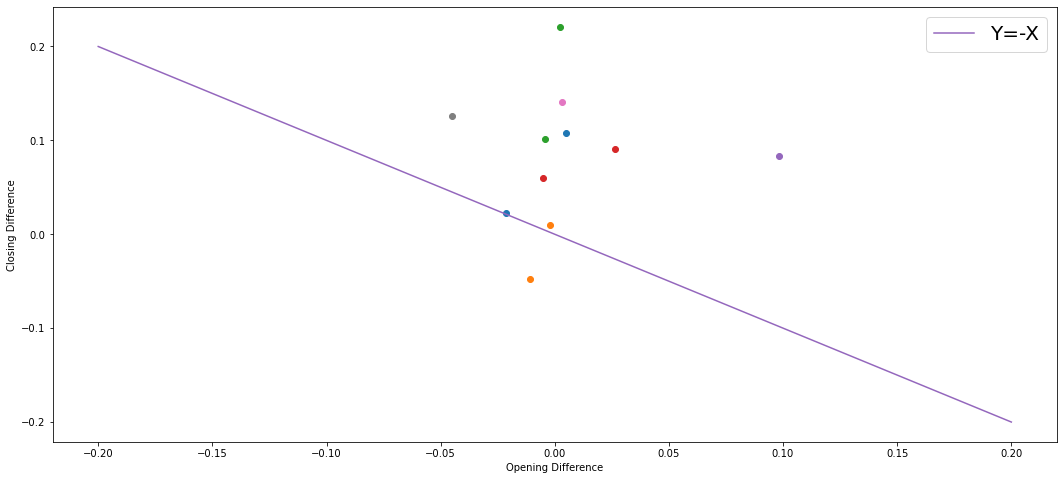

In [128]:
arr = os.listdir('../Data/State Closure Data/County Closure Data/')
print(arr)
fig,ax = plt.subplots(figsize = (18,8))
for file in arr:
    
    bBO = [] #Store the Beta Before Values
    bAO = [] #Store the Beta After Values
    bBC = []
    bAC = []
    
    pathc='../Data/JHU Data/County Data/'
    # modify the path syntax based on the current platform
    if platform.system() == "Windows":
        pathc.replace("/", "\\")
    if '.DS_Store' in file:
        continue
    #Change state abbreviation based on the state you want to use

    dates, infectRaw, recovRaw, deadRaw = SIRD_Model.loadData(pathc + file)
    
    
    cState = file[file.index(',')+2:len(file) -4] #Get the state abbreviation
    cName = convert[cState]
    cCounty = file[0:file.index(',')] #Get the county name

    #Change population based on the county you want to use
    pop = int(getPopC(cCounty,cState))
    numDays = len(infectRaw)
    infect = infectRaw[0:numDays]
    dead = deadRaw[0:numDays]

    gamma = getGamma(infect,dead)
    nu = getNu(infect,dead)
    q = 1 #0.0754
    window = 13
    hWin = window // 2
    beta = getBeta(pop, q, infect, dead, window)
    beta = betaWithKernel(beta)
    #fig, ax = plt.subplots(figsize= (18,8))
    #ax.plot(beta)
    temp = dates.tolist()
    pathc='../Data/State Closure Data/County Closure Data/'
    
    #Change function call of mM to change the policy
    sO = getStayAtHomeLifted(pathc+file, dates)
    sC =  getStayAtHome(pathc+file,dates)
    if (sO and sC):
        for k in range(len(sO)): 
            tBO, tAO = getBetaDiffC(dates,sO[k], beta, infect, dead, pop, q, numDays) 
            bBO.append(tBO)
            bAO.append(tAO)
        for k in range(len(sC)): 
            tBC, tAC = getBetaDiffC(dates,sC[k], beta, infect, dead, pop, q, numDays) 
            bBC.append(tBC)
            bAC.append(tAC)
    #Get beta before and after, getting a 14 day average before and a 14 day average after, starting 7 days after the policy
    bBO=np.array(bBO)
    bAO=np.array(bAO)
    bBC=np.array(bBC)
    bAC=np.array(bAC)
    print(bBO-bAO,bBC-bAC)
    ax.plot(np.mean(bBO-bAO), np.mean(bBC-bAC), 'o')
    
ax.plot([-0.2,0.2],[0.2,-0.2], label = "Y=-X")
ax.legend(fontsize = 20)
ax.set_xlabel("Opening Difference")
ax.set_ylabel("Closing Difference")